In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
    #transforms.GaussianBlur(kernel_size=9),
])

# Create the dataset
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\crop_simclr\train_plus_val"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2054])


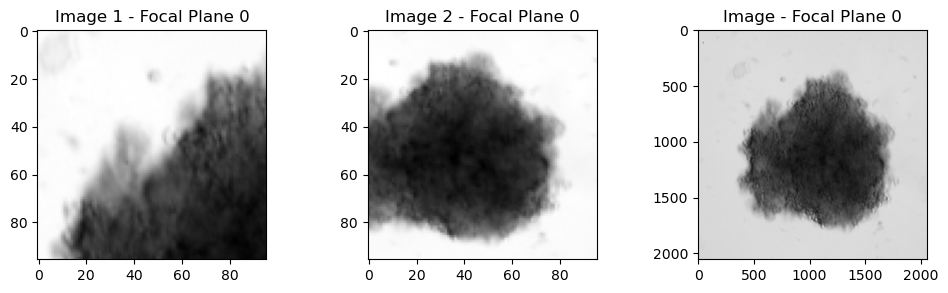

In [6]:
for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first focal plane (layer) for visualization
    layer_to_visualize = 0  # Change this to 1 or 2 if you want other layers
    
    plt.figure(figsize=(10, 3))
    
    # Normalize the 16-bit image to range [0, 1] for visualization
    image1_normalized = image1[0, layer_to_visualize].float()
    image2_normalized = image2[0, layer_to_visualize].float()
    image_normalized = image[0, layer_to_visualize].float()
    
    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1_normalized, cmap='gray')
    plt.title(f'Image 1 - Focal Plane {layer_to_visualize}')
    
    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2_normalized, cmap='gray')
    plt.title(f'Image 2 - Focal Plane {layer_to_visualize}')
    
    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image_normalized, cmap='gray')
    plt.title(f'Image - Focal Plane {layer_to_visualize}')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


# Load the pretrained UNet model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

In [7]:
class UNetEncoder(nn.Module):
    def __init__(self, unet_model,hidden_dim, lr, temperature, weight_decay, image_size=256, in_channel=3):
        super(UNetEncoder, self).__init__()
        self.image_size = image_size
        self.in_channel = in_channel
        self.temperature = temperature
        
        original_encoder1 = unet_model.encoder1
        
        # Create a new encoder1 layer with variable input channels, keeping the same output channels and kernel size
        self.encoder1 = nn.Sequential(
            nn.Conv2d(self.in_channel, original_encoder1[0].out_channels, 
                      kernel_size=original_encoder1[0].kernel_size, 
                      stride=original_encoder1[0].stride, 
                      padding=original_encoder1[0].padding),
            original_encoder1[1]  # Keep the rest of the layers (e.g., BatchNorm, ReLU) intact
        )
        
        self.pool1 = unet_model.pool1
        self.encoder2 = unet_model.encoder2
        self.pool2 = unet_model.pool2
        self.encoder3 = unet_model.encoder3
        self.pool3 = unet_model.pool3
        self.encoder4 = unet_model.encoder4
        self.pool4 = unet_model.pool4
        self.bottleneck = unet_model.bottleneck
        #dummy = torch.zeros((1, self.in_channel, image_size, image_size))
        #out = self.bottleneck(self.pool4(self.encoder4(self.pool3(self.encoder3(self.pool2(self.encoder2(self.pool1(self.encoder1(dummy)))))))))
        #shape = torch.flatten(out, start_dim=1).shape[1]
        #print(shape)
        #if I give shape instead of 18432 its shows mismatch between output of bottleneck and input of projection head. didn't figured it out why yet.
        
        # Define the fully connected layers after the bottleneck
        self.fc = nn.Sequential(
            nn.Linear(18432, 4 * hidden_dim),  # Adjust input size based on bottleneck output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        x = self.encoder1(x)
        x = self.pool1(x)
        x = self.encoder2(x)
        x = self.pool2(x)
        x = self.encoder3(x)
        x = self.pool3(x)
        x = self.encoder4(x)
        x = self.pool4(x)
        bottleneck = self.bottleneck(x)
        
        # Flatten the bottleneck output for the fully connected layer
        bottleneck_flat = torch.flatten(bottleneck, start_dim=1)
        print(f"Flattened bottleneck shape: {bottleneck_flat.shape}")
        
        # Pass through the fully connected layers
        output = self.fc(bottleneck_flat)
        
        # Return all encoder outputs or just bottleneck, depending on your needs
        return output, bottleneck
    
    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats,_ = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Load the pretrained UNet model
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)
    model = UNetEncoder(model,hidden_dim=hidden_dim,lr=lr, temperature=temperature, weight_decay=weight_decay,image_size=256, in_channel=3).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Training:   0%|          | 0/55 [00:00<?, ?it/s]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:   4%|▎         | 2/55 [00:02<01:17,  1.45s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:   5%|▌         | 3/55 [00:03<01:04,  1.24s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:   7%|▋         | 4/55 [00:04<00:58,  1.15s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:   9%|▉         | 5/55 [00:06<00:55,  1.11s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  11%|█         | 6/55 [00:07<00:56,  1.15s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  13%|█▎        | 7/55 [00:08<00:52,  1.10s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  15%|█▍        | 8/55 [00:09<00:52,  1.12s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  16%|█▋        | 9/55 [00:10<00:50,  1.09s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  18%|█▊        | 10/55 [00:11<00:47,  1.07s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  20%|██        | 11/55 [00:12<00:46,  1.05s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  22%|██▏       | 12/55 [00:13<00:47,  1.09s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  24%|██▎       | 13/55 [00:14<00:45,  1.07s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  25%|██▌       | 14/55 [00:15<00:43,  1.06s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  27%|██▋       | 15/55 [00:16<00:43,  1.09s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  29%|██▉       | 16/55 [00:18<00:43,  1.12s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  31%|███       | 17/55 [00:19<00:43,  1.14s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  33%|███▎      | 18/55 [00:20<00:42,  1.16s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  35%|███▍      | 19/55 [00:21<00:40,  1.12s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  36%|███▋      | 20/55 [00:22<00:38,  1.11s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  38%|███▊      | 21/55 [00:23<00:38,  1.13s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  40%|████      | 22/55 [00:24<00:37,  1.13s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  42%|████▏     | 23/55 [00:26<00:36,  1.14s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  44%|████▎     | 24/55 [00:26<00:33,  1.08s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  45%|████▌     | 25/55 [00:27<00:31,  1.03s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  47%|████▋     | 26/55 [00:28<00:29,  1.00s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  49%|████▉     | 27/55 [00:29<00:27,  1.01it/s]

Flattened bottleneck shape: torch.Size([32, 18432])
Flattened bottleneck shape: torch.Size([32, 18432])


Training:  53%|█████▎    | 29/55 [00:32<00:27,  1.05s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  55%|█████▍    | 30/55 [00:33<00:25,  1.03s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  56%|█████▋    | 31/55 [00:34<00:24,  1.02s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  58%|█████▊    | 32/55 [00:35<00:24,  1.08s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  60%|██████    | 33/55 [00:36<00:23,  1.06s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  62%|██████▏   | 34/55 [00:37<00:22,  1.06s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  64%|██████▎   | 35/55 [00:38<00:21,  1.08s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  65%|██████▌   | 36/55 [00:39<00:21,  1.12s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  67%|██████▋   | 37/55 [00:40<00:20,  1.17s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  69%|██████▉   | 38/55 [00:42<00:20,  1.18s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  71%|███████   | 39/55 [00:43<00:18,  1.14s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  73%|███████▎  | 40/55 [00:44<00:16,  1.10s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  75%|███████▍  | 41/55 [00:45<00:15,  1.09s/it]

Flattened bottleneck shape: torch.Size([32, 18432])
Flattened bottleneck shape: torch.Size([32, 18432])


Training:  78%|███████▊  | 43/55 [00:47<00:13,  1.17s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  80%|████████  | 44/55 [00:48<00:12,  1.13s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  82%|████████▏ | 45/55 [00:49<00:10,  1.10s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  84%|████████▎ | 46/55 [00:50<00:09,  1.08s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  85%|████████▌ | 47/55 [00:52<00:08,  1.12s/it]

Flattened bottleneck shape: torch.Size([32, 18432])
Flattened bottleneck shape: torch.Size([32, 18432])


Training:  89%|████████▉ | 49/55 [00:54<00:07,  1.17s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  91%|█████████ | 50/55 [00:55<00:05,  1.18s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  93%|█████████▎| 51/55 [00:56<00:04,  1.19s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  95%|█████████▍| 52/55 [00:58<00:03,  1.18s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  96%|█████████▋| 53/55 [00:59<00:02,  1.19s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Training:  98%|█████████▊| 54/55 [01:00<00:01,  1.15s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Flattened bottleneck shape: torch.Size([8, 18432])


Validating:   7%|▋         | 1/14 [00:00<00:12,  1.03it/s]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  14%|█▍        | 2/14 [00:01<00:11,  1.01it/s]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  21%|██▏       | 3/14 [00:03<00:11,  1.06s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  29%|██▊       | 4/14 [00:04<00:10,  1.07s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  36%|███▌      | 5/14 [00:05<00:09,  1.07s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  43%|████▎     | 6/14 [00:06<00:08,  1.11s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  50%|█████     | 7/14 [00:07<00:07,  1.09s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  57%|█████▋    | 8/14 [00:08<00:06,  1.09s/it]

Flattened bottleneck shape: torch.Size([32, 18432])
Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  71%|███████▏  | 10/14 [00:10<00:04,  1.12s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  79%|███████▊  | 11/14 [00:12<00:03,  1.14s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  86%|████████▌ | 12/14 [00:13<00:02,  1.10s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Validating:  93%|█████████▎| 13/14 [00:14<00:01,  1.07s/it]

Flattened bottleneck shape: torch.Size([32, 18432])


Flattened bottleneck shape: torch.Size([18, 18432])
Epoch 1/1 | Train Loss: 3.2219 | Top-1 Acc: 0.14% | Top-5 Acc: 0.38% | Mean Pos: 10.61 | Val Loss: 3.1830 | Top-1 Acc: 0.16% | Top-5 Acc: 0.39% | Mean Pos: 10.11 | Time Taken: 75.39 seconds
Total Training Time: 75.39 seconds


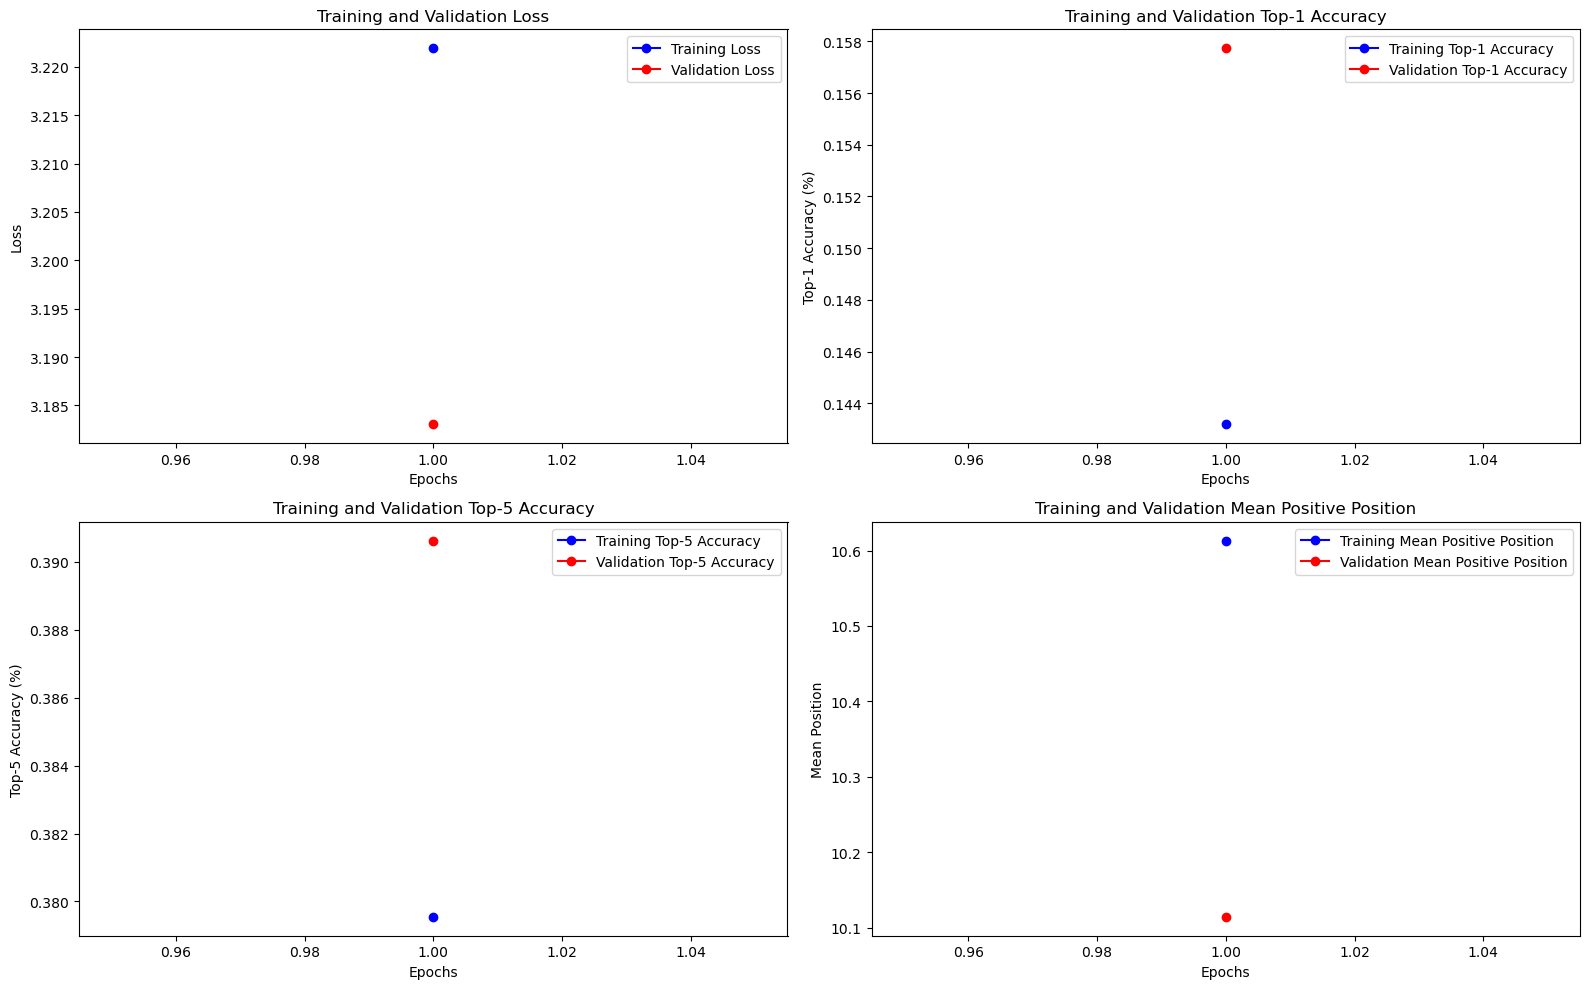

In [10]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=96, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=1)

# Logistic

In [12]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [13]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0])


In [14]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model)
    network.fc = nn.Identity()  # Remove the fully connected layer
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)

        # Unpack the outputs from the model
        _, bottleneck_feats = network(batch_imgs)  # Retrieve only bottleneck features
        print(f"Batch bottleneck features shape: {bottleneck_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        # Collect bottleneck features and labels
        feats.append(bottleneck_feats.detach().cpu())
        labels.append(batch_labels)

    # Concatenate all batches
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)


In [15]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

 33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

Flattened bottleneck shape: torch.Size([16, 18432])
Batch bottleneck features shape: torch.Size([16, 512, 6, 6])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]

Flattened bottleneck shape: torch.Size([16, 18432])
Batch bottleneck features shape: torch.Size([16, 512, 6, 6])
Batch labels shape: torch.Size([16])


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Flattened bottleneck shape: torch.Size([16, 18432])
Batch bottleneck features shape: torch.Size([16, 512, 6, 6])
Batch labels shape: torch.Size([16])
Features shape after concatenation: torch.Size([48, 512, 6, 6])
Labels shape after concatenation: torch.Size([48])


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Flattened bottleneck shape: torch.Size([12, 18432])
Batch bottleneck features shape: torch.Size([12, 512, 6, 6])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([12, 512, 6, 6])
Labels shape after concatenation: torch.Size([12])


In [30]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [31]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [32]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [33]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.7857, Training accuracy: 0.6140
Test loss: 0.5712, Test accuracy: 0.7333
Epoch 2/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 818.80it/s]


Training loss: 0.3398, Training accuracy: 0.8772
Test loss: 0.1678, Test accuracy: 0.9333
Epoch 3/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.2061, Training accuracy: 0.9298
Test loss: 0.1441, Test accuracy: 0.9333
Epoch 4/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0823, Training accuracy: 1.0000
Test loss: 0.1744, Test accuracy: 0.8667
Epoch 5/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0558, Training accuracy: 1.0000
Test loss: 0.1351, Test accuracy: 0.9333
Epoch 6/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.12it/s]


Training loss: 0.0544, Training accuracy: 1.0000
Test loss: 0.1313, Test accuracy: 1.0000
Epoch 7/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0481, Training accuracy: 1.0000
Test loss: 0.1279, Test accuracy: 1.0000
Epoch 8/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0423, Training accuracy: 1.0000
Test loss: 0.1246, Test accuracy: 1.0000
Epoch 9/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0520, Training accuracy: 1.0000
Test loss: 0.1211, Test accuracy: 1.0000
Epoch 10/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.14it/s]


Training loss: 0.0418, Training accuracy: 1.0000
Test loss: 0.1180, Test accuracy: 1.0000
Epoch 11/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0406, Training accuracy: 1.0000
Test loss: 0.1142, Test accuracy: 1.0000
Epoch 12/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0400, Training accuracy: 1.0000
Test loss: 0.1104, Test accuracy: 1.0000
Epoch 13/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 821.12it/s]


Training loss: 0.0386, Training accuracy: 1.0000
Test loss: 0.1072, Test accuracy: 1.0000
Epoch 14/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0452, Training accuracy: 1.0000
Test loss: 0.1039, Test accuracy: 1.0000
Epoch 15/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0558, Training accuracy: 1.0000
Test loss: 0.1001, Test accuracy: 1.0000
Epoch 16/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1000.07it/s]


Training loss: 0.0444, Training accuracy: 1.0000
Test loss: 0.0975, Test accuracy: 1.0000
Epoch 17/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 999.36it/s]


Training loss: 0.0444, Training accuracy: 1.0000
Test loss: 0.0947, Test accuracy: 1.0000
Epoch 18/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1178.51it/s]


Training loss: 0.0375, Training accuracy: 1.0000
Test loss: 0.0913, Test accuracy: 1.0000
Epoch 19/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1526.03it/s]


Training loss: 0.0353, Training accuracy: 1.0000
Test loss: 0.0889, Test accuracy: 1.0000
Epoch 20/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0349, Training accuracy: 1.0000
Test loss: 0.0870, Test accuracy: 1.0000
Epoch 21/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1000.43it/s]


Training loss: 0.0343, Training accuracy: 1.0000
Test loss: 0.0851, Test accuracy: 1.0000
Epoch 22/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]


Training loss: 0.0344, Training accuracy: 1.0000
Test loss: 0.0832, Test accuracy: 1.0000
Epoch 23/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0387, Training accuracy: 1.0000
Test loss: 0.0819, Test accuracy: 1.0000
Epoch 24/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0382, Training accuracy: 1.0000
Test loss: 0.0797, Test accuracy: 1.0000
Epoch 25/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.94it/s]


Training loss: 0.0336, Training accuracy: 1.0000
Test loss: 0.0778, Test accuracy: 1.0000
Epoch 26/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0330, Training accuracy: 1.0000
Test loss: 0.0763, Test accuracy: 1.0000
Epoch 27/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0405, Training accuracy: 1.0000
Test loss: 0.0750, Test accuracy: 1.0000
Epoch 28/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0377, Training accuracy: 1.0000
Test loss: 0.0734, Test accuracy: 1.0000
Epoch 29/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0377, Training accuracy: 1.0000
Test loss: 0.0720, Test accuracy: 1.0000
Epoch 30/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0366, Training accuracy: 1.0000
Test loss: 0.0709, Test accuracy: 1.0000
Epoch 31/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0320, Training accuracy: 1.0000
Test loss: 0.0701, Test accuracy: 1.0000
Epoch 32/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0383, Training accuracy: 1.0000
Test loss: 0.0693, Test accuracy: 1.0000
Epoch 33/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0347, Training accuracy: 1.0000
Test loss: 0.0681, Test accuracy: 1.0000
Epoch 34/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0318, Training accuracy: 1.0000
Test loss: 0.0669, Test accuracy: 1.0000
Epoch 35/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.59it/s]


Training loss: 0.0322, Training accuracy: 1.0000
Test loss: 0.0661, Test accuracy: 1.0000
Epoch 36/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0389, Training accuracy: 1.0000
Test loss: 0.0661, Test accuracy: 1.0000
Epoch 37/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0363, Training accuracy: 1.0000
Test loss: 0.0666, Test accuracy: 1.0000
Epoch 38/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0409, Training accuracy: 1.0000
Test loss: 0.0669, Test accuracy: 1.0000
Epoch 39/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0362, Training accuracy: 1.0000
Test loss: 0.0658, Test accuracy: 1.0000
Epoch 40/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0307, Training accuracy: 1.0000
Test loss: 0.0656, Test accuracy: 1.0000
Epoch 41/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2002.05it/s]


Training loss: 0.0309, Training accuracy: 1.0000
Test loss: 0.0653, Test accuracy: 1.0000
Epoch 42/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 999.83it/s]


Training loss: 0.0364, Training accuracy: 1.0000
Test loss: 0.0647, Test accuracy: 1.0000
Epoch 43/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1996.81it/s]


Training loss: 0.0317, Training accuracy: 1.0000
Test loss: 0.0639, Test accuracy: 1.0000
Epoch 44/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0307, Training accuracy: 1.0000
Test loss: 0.0635, Test accuracy: 1.0000
Epoch 45/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0306, Training accuracy: 1.0000
Test loss: 0.0632, Test accuracy: 1.0000
Epoch 46/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0302, Training accuracy: 1.0000
Test loss: 0.0629, Test accuracy: 1.0000
Epoch 47/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0301, Training accuracy: 1.0000
Test loss: 0.0627, Test accuracy: 1.0000
Epoch 48/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0313, Training accuracy: 1.0000
Test loss: 0.0625, Test accuracy: 1.0000
Epoch 49/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.03it/s]


Training loss: 0.0303, Training accuracy: 1.0000
Test loss: 0.0624, Test accuracy: 1.0000
Epoch 50/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0299, Training accuracy: 1.0000
Test loss: 0.0622, Test accuracy: 1.0000


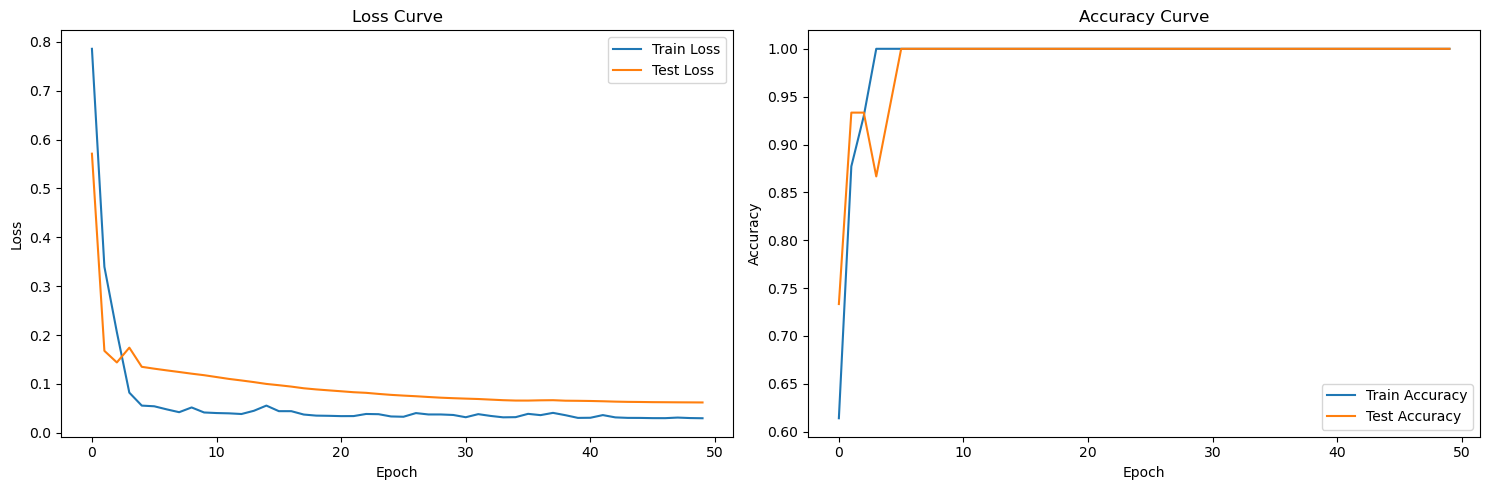

In [34]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=50
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")
